
# Lesson 3 — Logistic Regression (Deep Dive)

This lesson builds **from first principles** toward logistic regression, closely following
Andrew Ng’s original CS229 narrative while adding **modern visualizations, intuition,
and diagnostics**.

We will move through:

1. Linear regression recap (geometry + loss surface)
2. Locally weighted regression (non‑parametric intuition)
3. Probabilistic interpretation of linear regression (MLE)
4. Logistic regression as Bernoulli MLE
5. Optimization via Gradient Ascent vs Newton’s Method
6. Visual diagnostics: decision surfaces, confidence, convergence

This lesson is intentionally **conceptual + visual**, not just implementation.



## Imports & Setup


In [19]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

np.random.seed(42)
plt.style.use("dark_background")



## Dataset: Breast Cancer (Binary Classification)

We use the breast cancer dataset:
- **y = 1** → malignant
- **y = 0** → benign

Features are standardized to simplify optimization geometry.


In [20]:

X_raw, y_raw = datasets.load_breast_cancer(return_X_y=True)

X = (X_raw - X_raw.mean(axis=0)) / X_raw.std(axis=0)
y = y_raw.reshape(-1, 1)

m, n = X.shape
Xb = np.hstack([np.ones((m,1)), X])

print(f"{m} samples, {n} features (+ bias)")


569 samples, 30 features (+ bias)



## Linear Regression (Why It Fails for Classification)

Linear regression:
- Predicts **unbounded outputs**
- Is **sensitive to outliers**
- Produces unstable decision thresholds

We visualize this failure explicitly.


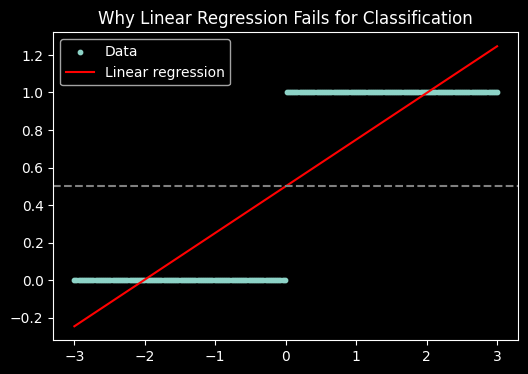

In [21]:

# 1D synthetic classification example
X1 = np.linspace(-3, 3, 200).reshape(-1,1)
y1 = (X1[:,0] > 0).astype(int)

Xb1 = np.c_[np.ones(len(X1)), X1]

theta_lr = np.linalg.pinv(Xb1.T @ Xb1) @ Xb1.T @ y1

plt.figure(figsize=(6,4))
plt.scatter(X1, y1, s=10, label="Data")
plt.plot(X1, Xb1 @ theta_lr, color="red", label="Linear regression")
plt.axhline(0.5, linestyle="--", color="gray")
plt.title("Why Linear Regression Fails for Classification")
plt.legend()
plt.show()



## Locally Weighted Linear Regression (LWLR)

LWLR fits **a new model per query point**, weighting nearby examples more heavily.

Key ideas:
- Non‑parametric
- No global θ
- Bandwidth τ controls bias‑variance tradeoff


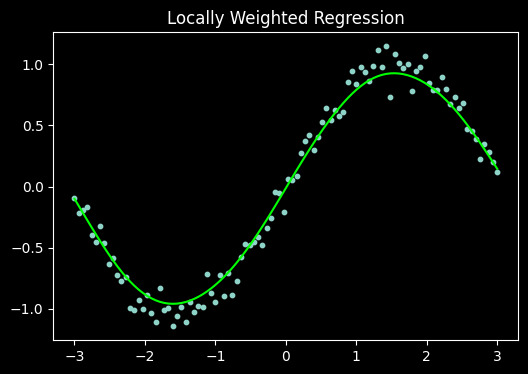

In [22]:

def lwlr_predict(X, y, x0, tau):
    W = np.exp(-np.sum((X - x0)**2, axis=1) / (2*tau**2))
    W = np.diag(W)
    theta = np.linalg.pinv(X.T @ W @ X) @ X.T @ W @ y
    return x0 @ theta

# demo
X_demo = np.linspace(-3,3,100).reshape(-1,1)
y_demo = np.sin(X_demo) + 0.1*np.random.randn(100,1)
Xb_demo = np.c_[np.ones(len(X_demo)), X_demo]

preds = np.array([lwlr_predict(Xb_demo, y_demo, x0, tau=0.4) for x0 in Xb_demo])

plt.figure(figsize=(6,4))
plt.scatter(X_demo, y_demo, s=10)
plt.plot(X_demo, preds, color="lime")
plt.title("Locally Weighted Regression")
plt.show()



## Probabilistic Interpretation of Linear Regression

Assumption:
$$ y = θ^T x + ε $$

where:
$$ ε \sim \mathcal{N}(0, σ^2) $$

Maximizing likelihood ⟺ minimizing squared error.

This is **why MSE exists** — not arbitrary.



## Logistic Regression: Modeling Probabilities

For classification:
$$ y ∈ \{0,1\} $$

We model:
$$ P(y=1 | x; θ) = σ(θ^T x) $$

where:
$$ σ(z) = \frac{1}{1+e^{-z}} $$

This guarantees outputs in **[0,1]** and yields a **concave likelihood**.


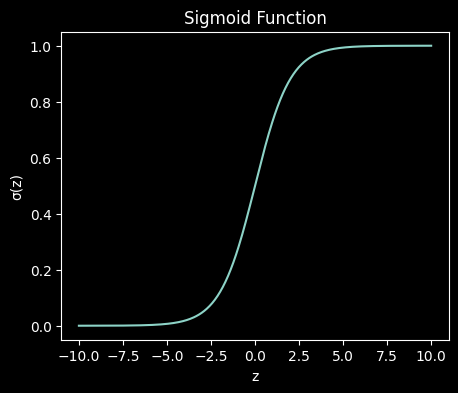

In [23]:

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-10,10,400)
plt.figure(figsize=(5,4))
plt.plot(z, sigmoid(z))
plt.title("Sigmoid Function")
plt.xlabel("z")
plt.ylabel("σ(z)")
plt.show()



## Logistic Regression Loss (Negative Log‑Likelihood)

The Bernoulli likelihood yields the **cross‑entropy loss**:

$$
J(θ) = -\frac{1}{m} \sum y\log(h) + (1-y)\log(1-h)
$$

Convex → **no local minima**.


In [24]:

def log_loss(Xb, y, theta):
    h = sigmoid(Xb @ theta)
    h = np.clip(h,1e-9,1-1e-9)
    return -np.mean(y*np.log(h)+(1-y)*np.log(1-h))

def log_grad(Xb, y, theta):
    return Xb.T @ (sigmoid(Xb @ theta) - y) / len(y)



## Gradient Ascent vs Newton’s Method

Gradient ascent:
- Cheap iterations
- Slow convergence

Newton’s method:
- Uses curvature (Hessian)
- Few iterations
- Expensive per step


In [25]:

def train_gd(Xb, y, lr=0.1, epochs=300):
    theta = np.zeros((Xb.shape[1],1))
    hist=[]
    for _ in range(epochs):
        hist.append(log_loss(Xb,y,theta))
        theta -= lr*log_grad(Xb,y,theta)
    return theta, hist

def hessian(Xb, theta):
    h = sigmoid(Xb @ theta)
    R = np.diag((h*(1-h)).flatten())
    return Xb.T @ R @ Xb / len(h)

def train_newton(Xb,y,iters=15):
    theta = np.zeros((Xb.shape[1],1))
    hist=[]
    for _ in range(iters):
        hist.append(log_loss(Xb,y,theta))
        theta -= np.linalg.solve(hessian(Xb,theta)+1e-4*np.eye(Xb.shape[1]), log_grad(Xb,y,theta))
    return theta, hist


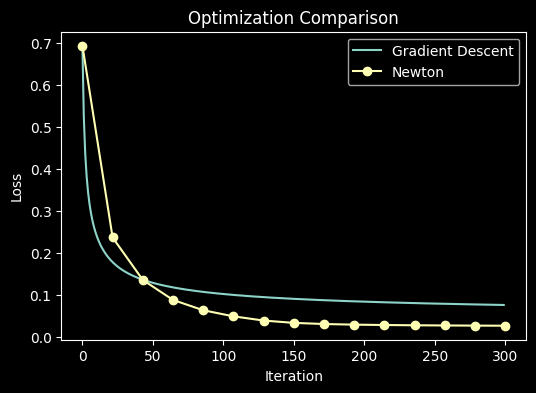

In [26]:

theta_gd, hist_gd = train_gd(Xb,y)
theta_nt, hist_nt = train_newton(Xb,y)

plt.figure(figsize=(6,4))
plt.plot(hist_gd,label="Gradient Descent")
plt.plot(np.linspace(0,len(hist_gd),len(hist_nt)),hist_nt,'o-',label="Newton")
plt.title("Optimization Comparison")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()



## Decision Boundary Visualization (PCA Space)


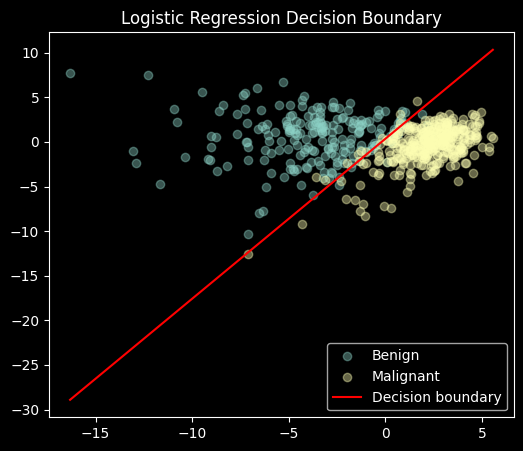

In [27]:

U,S,Vt = np.linalg.svd(X, full_matrices=False)
X2 = X @ Vt.T[:,:2]
Xb2 = np.c_[np.ones(len(X2)), X2]

theta2,_ = train_newton(Xb2,y)

xx = np.linspace(X2[:,0].min(), X2[:,0].max(),200)
yy = -(theta2[0]+theta2[1]*xx)/theta2[2]

plt.figure(figsize=(6,5))
plt.scatter(X2[y.flatten()==0][:,0],X2[y.flatten()==0][:,1],alpha=0.4,label="Benign")
plt.scatter(X2[y.flatten()==1][:,0],X2[y.flatten()==1][:,1],alpha=0.4,label="Malignant")
plt.plot(xx,yy,'r',label="Decision boundary")
plt.legend()
plt.title("Logistic Regression Decision Boundary")
plt.show()



## Key Takeaways

- Linear regression assumes **Gaussian noise**
- Logistic regression assumes **Bernoulli outcomes**
- Cross‑entropy = negative log‑likelihood
- Logistic loss is convex → global optimum
- Newton’s method exploits curvature for fast convergence
- LWLR trades memory + compute for flexibility
